# Import The Libraries

In [12]:
import pandas as pd
import os
import csv
from influxdb import InfluxDBClient
from matplotlib import pyplot
from fpdf import FPDF
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
from datetime import date
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

import warnings
warnings.filterwarnings("ignore")

# Setup Connection with influxdb Client

In [7]:
client=InfluxDBClient('localhost',8086,'Janvimadhu','Janvimadhu098*')
client.create_database('server_disk_usage_prediction')
client.switch_database('server_disk_usage_prediction')
client.get_list_database()

[{'name': '_internal'},
 {'name': 'server_disk_usage'},
 {'name': 'server_disk_usage_prediction'},
 {'name': 'server_disk'}]

# Read the Data From CSV and write into the influx Database

In [8]:
def read_total_objects():
    with open('./Data/totalobjects_aerospike_zeus_full.csv') as file:
        return [x.split(',') for x in file.readlines()[1:]]
    
def read_memory_data():
    with open('./Data/memory_zeus_full.csv') as f:
        return [x.split(',') for x in file.readlines()[1:]]

def read_disk_data():
    with open('./Data/device_used_bytes_aerospike_zeus_full.csv') as f:
        return [x.split(',') for x in file.readlines()[1:]]

def write_point_memory_data():
    lines=read_memory_data()
    for data in lines:
        name=data[0]
        s=data[1]
        json_body=[{
            "measurement" : name,
            "tags" : {
                "host" : data[2]
            },
            "time" : pd.to_datetime(s),
            "fields" : {
                "value" : float(data[3].rstrip("\n"))
            }
        }]
        print(json_body)
        client.switch_user("Janvimadhu","Janvimadhu098*")
        client.write_points(points=json_body,database="server_disk_usage_prediction",batch_size=500_000)
        
        
def write_point_disk_data():
    lines=read_disk_data()
    for data in lines:
        name=data[0]
        s=data[1]
        json_body=[{
            "measurement" : name,
            "tags" : {
                "host" : data[2]
            },
            "time" : pd.to_datetime(s),
            "fields" : {
                "value" : float(data[3].rstrip("\n"))
            }
        }]
        print(json_body)
        client.switch_user("Janvimadhu","Janvimadhu098*")
        client.write_points(points=json_body,database="server_disk_usage_prediction",batch_size=500_000)
        
def write_point_total_objects():
    lines=read_total_objects()
    for data in lines:
        name=data[0]
        s=data[1]
        json_body=[{
            "measurement" : name,
            "tags" : {
                "host" : data[2]
            },
            "time" : pd.to_datetime(s),
            "fields" : {
                "value" : float(data[3].rstrip("\n"))
            }
        }]
        print(json_body)
        client.switch_user("Janvimadhu","Janvimadhu098*")
        client.write_points(points=json_body,database="server_disk_usage_prediction",batch_size=500_000)

#write_point_memory_data()
#write_point_disk_data()
#write_point_total_objects()
    

# Functions required for the Project 

In [9]:
def select_and_visualize(filename=None):
    measurement = input("Enter the Query to Select Data from the influxdb measurement: ")
    select_points=pd.DataFrame(client.query(measurement).get_points())
    select_points['time'] = pd.to_datetime(select_points['time'])
    df_plot=select_points.set_index(['time'])
    start_date = input("Provide start interval time in the format of YY-MM-DD HH:MM:SS: ")
    end_date = input("Provide end interval time in the format of YY-MM-DD HH:MM:SS: ")
    fr = input("Provide frequency to which we need to resample: ")
    df_resampled = (select_points.loc[select_points["time"].between(start_date, end_date)]).groupby(pd.Grouper(key="time", freq=fr)).mean()
    rgc_hour=df_resampled.pct_change()
    df_resampled['value'].plot(color='g',linewidth=1,label='Resampled Data by '+ fr)
    rgc_hour['value'].plot(color='r',linewidth=1,label='Rate of growth change of Resampled Data by ' + fr)
    filename=filename
    save_file(filename)
    while True:
        option= input("Enter YES or NO if you already have an existing continuous query or want to create a new continuous query? ")
        if(option== 'no'):
            break    
        if(option == 'YES' or option == 'Yes' or option=='yes' or option == 'Y' or option == 'y'):
            cq=input("Enter the name of the continuous query you wish to create: ")
            group_by = input("Enter the way in which you would like to downsample the data: (For ex: groupby: 1d) ")
            resampling_option = input("Enter the Resampling option data you would like to put: ")
            query="SELECT mean(value) INTO " + cq + " FROM " + measurement_name + " GROUP BY time(" + group_by + ")"
            client.create_continuous_query(cq, query,'server_disk_usage_prediction', resampling_option) 
            
    globals().update(locals())
    
def downsampling(filename_daily=None,filename_weekly=None):
    downsampled_select_data = input("Enter the Query to Select the Downsampled Data: ")
    get_downsampled_data=pd.DataFrame(client.query(downsampled_select_data).get_points())
    get_downsampled_data['time'] = pd.to_datetime(get_downsampled_data['time'])
    df_plot_time=get_downsampled_data.set_index(['time'])
    growth=df_plot_time['mean'].pct_change()
    df_plot_time['growth']=growth
    df_plot_time['growth']=df_plot_time['growth']
    df_plot_time['mean'].plot(color="green",linewidth=1,label='Downsampled Data Averge per Day')
    df_plot_time['growth'].plot(color="red",linewidth=1,label='Downsampled Data Growth for per Day')
    filename=filename_daily
    save_file(filename)
    downsampled_select_data_weekly = input("Enter the Query to Select the Downsampled Data: ")
    get_downsampled_data_1w=pd.DataFrame(client.query(downsampled_select_data_weekly).get_points())
    get_downsampled_data_1w['time'] = pd.to_datetime(get_downsampled_data_1w['time'])
    df_plot_time_1w=get_downsampled_data_1w.set_index(['time'])
    growth=df_plot_time_1w['mean'].pct_change()
    df_plot_time_1w['growth']=growth
    df_plot_time_1w['growth']=df_plot_time_1w['growth']
    df_plot_time_1w['mean'].plot(color="green",linewidth=1,label='Downsampled Data Averge per Week')
    df_plot_time_1w['growth'].plot(color="red",linewidth=1,label='Downsampled Data Growth per Week')
    filename=filename_weekly
    save_file(filename)
    globals().update(locals())

def save_file(filename):
    pyplot.legend(loc='best')
    pyplot.title(measurement_name)
    pyplot.savefig(filename)
    pyplot.close()
    
def univariate_prediction_memory():
    df_memory=merged_df
    df_memory=df_memory.reset_index()
    df_memory=df_memory.drop(columns=['objects','devices_bytes'])
    df_memory.columns = ['ds','y']
    df_memory['ds'] = pd.to_datetime(df_memory['ds'])
    train_memory=df_memory[(df_memory['ds'] >= '2022-03-24') & (df_memory['ds'] <= '2022-05-11')]
    model_memory=Prophet(weekly_seasonality=False)
    model_memory.add_seasonality(name='monthly', period=30, fourier_order=6)
    model_memory.fit(train_memory)
    future_dates_memory=model_memory.make_future_dataframe(periods=4, freq='d')
    prediction_memory=model_memory.predict(future_dates_memory)
    pd.concat([df_memory.set_index('ds')['y'],prediction_memory.set_index('ds')['yhat']],axis=1).plot()
    pyplot.title('Difference between Actual and Predicted Memory')
    filename="./prediction/memory_actual_predicted_difference.png"
    pyplot.savefig(filename)
    model_memory.plot(prediction_memory)
    pyplot.title("Prophet Forecast Memory")
    filename="./prediction/memory_forecast.png"
    pyplot.savefig(filename)
    fig2 = model_memory.plot_components(prediction_memory)
    pyplot.title("Prophet Forecast Components for Memory")
    filename="./prediction/memory_forecast_components.png"
    pyplot.savefig(filename)
    pyplot.close()
    metric_df_memory = prediction_memory.set_index('ds')[['yhat']].join(train_memory.set_index('ds').y).reset_index()
    metric_df_memory.dropna(inplace=True)
    globals().update(locals())
    
def univariate_prediction_objects():
    df_objects=merged_df
    df_objects=df_objects.reset_index()
    df_objects=df_objects.drop(columns=['memory','devices_bytes'])
    df_objects.columns = ['ds','y']
    df_objects['ds'] = pd.to_datetime(df_objects['ds'])
    train_objects=df_objects[(df_objects['ds'] >= '2022-04-19') & (df_objects['ds'] <= '2022-05-11')]
    model_objects=Prophet(weekly_seasonality=False)
    model_objects.add_seasonality(name='bi-weekly', period=14,fourier_order=6)
    model_objects.fit(train_objects)
    future_dates_objects=model_objects.make_future_dataframe(periods=4, freq='d')
    prediction_objects=model_objects.predict(future_dates_objects)
    pd.concat([df_objects.set_index('ds')['y'],prediction_objects.set_index('ds')['yhat']],axis=1).plot()
    pyplot.title('Difference between actual and predicted objects')
    filename="./prediction/Objects_actual_predicted_difference.png"
    pyplot.savefig(filename)
    model_objects.plot(prediction_objects)
    pyplot.title("Prophet Forecast Objects")
    filename="./prediction/Objects_forecast.png"
    pyplot.savefig(filename)
    fig2 = model_objects.plot_components(prediction_objects)
    pyplot.title("Prophet Forecast Components for Objects")
    filename="./prediction/Objects_forecast_components.png"
    pyplot.savefig(filename)
    pyplot.close()
    metric_df_objects = prediction_objects.set_index('ds')[['yhat']].join(train_objects.set_index('ds').y).reset_index()
    metric_df_objects.dropna(inplace=True)
    globals().update(locals())
    
def prediction(new_df_memory,new_df_objects):
    new_df_disk=merged_df.reset_index()[['time','objects','devices_bytes','memory']].rename({'time':'ds','objects':'objects','memory':'memory','devices_bytes':'y'}, axis='columns')
    train_disk=new_df_disk[(new_df_disk['ds'] >= '2022-04-19') & (new_df_disk['ds'] <= '2022-05-11')]
    m_disk = Prophet(weekly_seasonality=False,changepoint_prior_scale=0.08)
    m_disk.add_regressor('memory')
    m_disk.add_regressor('objects')
    m_disk.add_seasonality(name='bi-weekly', period=14,fourier_order=6)
    m_disk.fit(train_disk)
    future = m_disk.make_future_dataframe(periods=4,freq='d')
    future['memory'] = new_df_memory['yhat']
    future['objects'] = new_df_objects['yhat']
    forecast = m_disk.predict(future)
    fig=pd.concat([new_df_disk.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()
    pyplot.title("Difference between the actual & The Predicted values of Disk(devices_used_bytes)")
    filename="./prediction/Devices_used_bytes_Actual_Predicted_Difference.png"
    pyplot.savefig(filename)
    m_disk.plot(forecast)
    pyplot.title("Prophet Forecast Disk(devices_used_bytes)")
    filename="./prediction/Devices_used_bytes_Forecast.png"
    pyplot.savefig(filename)
    fig2 = m_disk.plot_components(forecast)
    pyplot.title("Prophet Forecast Components for Disk(device_used_bytes)")
    filename="./prediction/Devices_used_bytes_Forecast_Components.png"
    pyplot.savefig(filename)
    pyplot.close()
    metric_df_disk = forecast.set_index('ds')[['yhat']].join(train_disk.set_index('ds').y).reset_index()
    metric_df_disk.dropna(inplace=True)
    globals().update(locals())
    
       

# Implementation of all the above function and the project 

Enter the Query to Select Data from the influxdb measurement: select * from device_used_bytes_zeus
Provide start interval time in the format of YY-MM-DD HH:MM:SS: 2022-03-23T07:12:14Z
Provide end interval time in the format of YY-MM-DD HH:MM:SS: 2022-05-11T13:11:37Z
Provide frequency to which we need to resample: 1H
Enter YES or NO if you already have an existing continuous query or want to create a new continuous query? no
Enter the Query to Select the Downsampled Data: select * from downsampled_data_24hr_devices
Enter the Query to Select the Downsampled Data: select * from downsampled_data_1w_devices
Enter the Query to Select Data from the influxdb measurement: select * from objects
Provide start interval time in the format of YY-MM-DD HH:MM:SS: 2022-03-23T07:11:14Z
Provide end interval time in the format of YY-MM-DD HH:MM:SS: 2022-05-11T13:11:37Z
Provide frequency to which we need to resample: 1H
Enter YES or NO if you already have an existing continuous query or want to create a ne

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


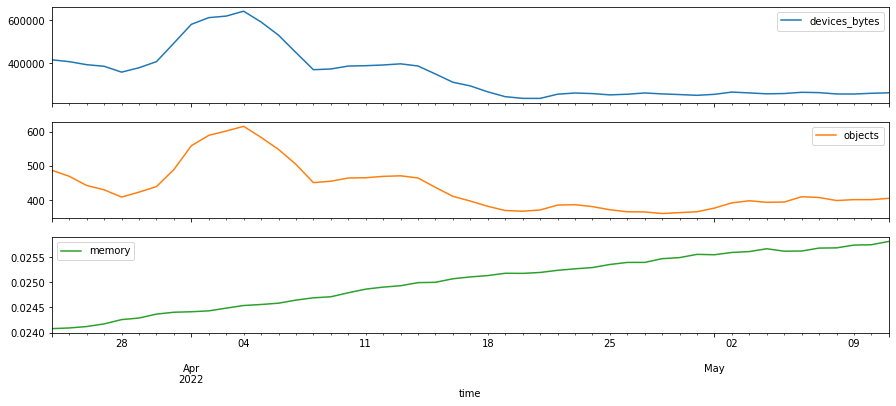

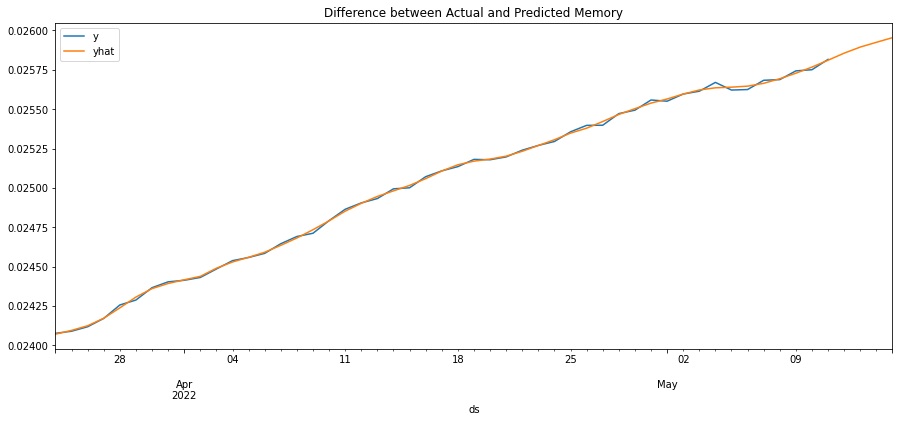

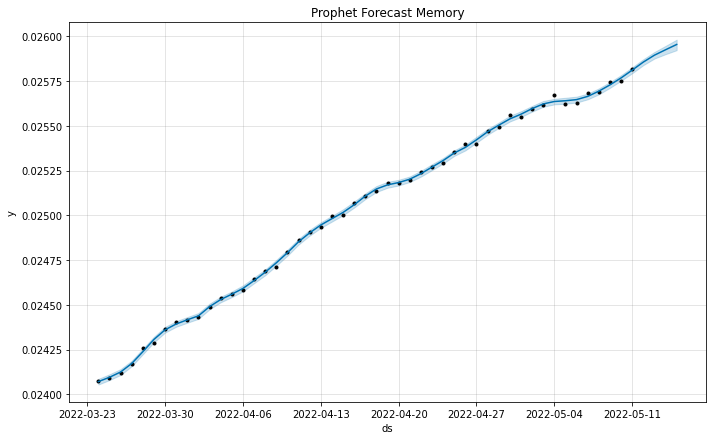

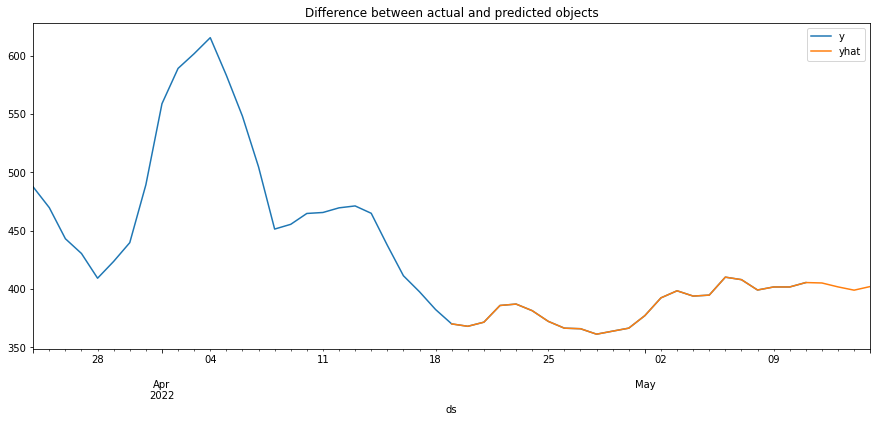

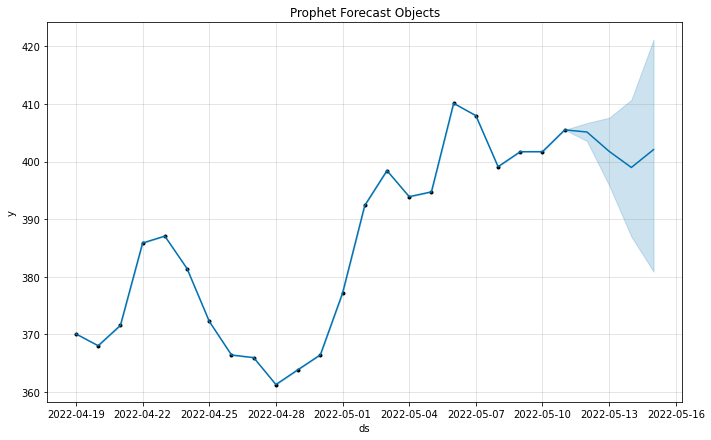

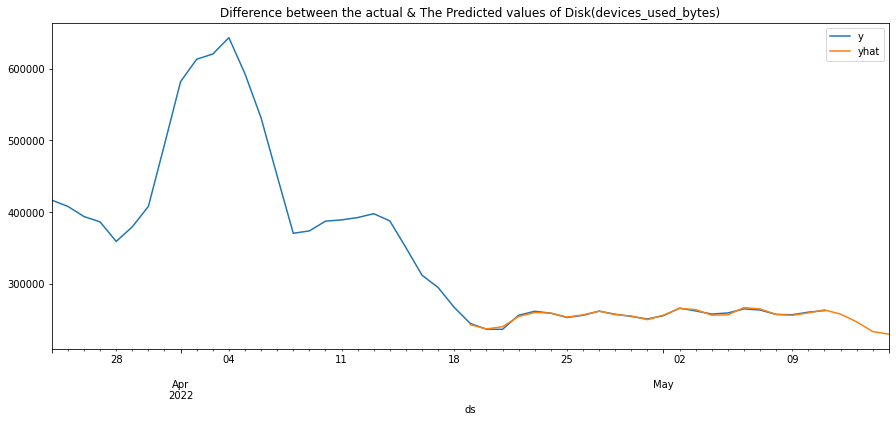

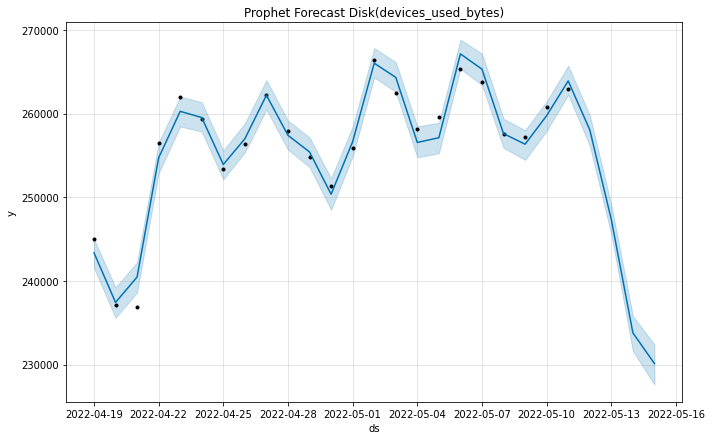

In [10]:
if __name__ == "__main__":
    l= ['device_used_bytes_zeus','objects','memory']
    df_merge= pd.DataFrame(columns={'time'})
    for i in l:
        measurement_name = i
        filename_path="./resources/"+measurement_name+"_data.png"
        downsampled_data_24Hr_filename = "./resources/"+measurement_name+"_downsampled_data_24Hr.png"
        downsampled_data_1w_filename = "./resources/"+measurement_name+"_downsampled_data_1w.png"
        select_and_visualize(filename=filename_path)
        downsampling(filename_daily=downsampled_data_24Hr_filename,filename_weekly=downsampled_data_1w_filename)
        df_merge=pd.merge(df_merge,get_downsampled_data,on='time',how='outer')
    df_merge.rename(columns={'mean_x':'devices_bytes' ,'mean_y':'objects','mean':'memory'},inplace=True)
    df_merge['time']=df_merge['time'].dt.tz_localize(None)
    df_merge['memory']=df_merge['memory'].fillna(method='bfill')
    df_merge['devices_bytes']=df_merge['devices_bytes'].fillna(method='ffill')
    df_merge['objects']=df_merge['objects'].fillna(method='ffill')
    new_df=df_merge.set_index('time')
    new_df.plot(subplots=True)
    filename="./resources/sub_plots.png"
    pyplot.savefig(filename)
    fig = px.line(df_merge, x='time', y='devices_bytes', hover_data=['objects','memory'], title='Server Disk Usage',width=1000, height=400)
    fig.show()
    merged_df=new_df
    univariate_prediction_memory()
    univariate_prediction_objects()
    new_df_memory=prediction_memory[['ds','yhat']].iloc[26:]
    new_df_memory=new_df_memory.reset_index()
    new_df_memory=new_df_memory.drop(columns=['index'])
    new_df_objects=prediction_objects[['ds','yhat']]
    prediction(new_df_memory,new_df_objects)


# Generation of Report on the basis of the Downsampled Data 

In [13]:
WIDTH=210
HEIGHT=297
TEST_DATE = date.today()

def create_title_everyday_week(day,pdf):
    pdf.set_font('Arial','',24)
    pdf.ln(10)
    pdf.write(5, f"DISK USAGE REPORT")
    pdf.ln(10)
    pdf.set_font('Arial','',16)
    pdf.write(4,f'{day}')
    pdf.ln(5)
    
def create_analytical_report(day=TEST_DATE,filename="./analytical_reports/data_analytics.pdf"):
    pdf= FPDF()
    '''FIRST PAGE'''
    pdf.add_page()
    create_title_everyday_week(day,pdf)
    pdf.set_font('Arial','',10)
    pdf.ln(15)
    pdf.write(5,f"Data")
    pdf.ln(2)
    pdf.image("./resources/objects_data.png",5,50,WIDTH-20)
    pdf.image("./resources/device_used_bytes_zeus_data.png",5,120,WIDTH-20)
    pdf.image("./resources/memory_data.png",5,190,WIDTH-20)
    

    '''SECOND PAGE'''
    pdf.add_page()
    pdf.ln(10)
    pdf.write(5,f"Mean & Rate of Growth of each metrics per Day")
    pdf.image("./resources/objects_downsampled_data_24Hr.png",5,30,WIDTH-20)
    pdf.image("./resources/device_used_bytes_zeus_downsampled_data_24Hr.png",5,110,WIDTH-20)
    pdf.image("./resources/memory_downsampled_data_24Hr.png",5,190,WIDTH-20)
    
    
    
    '''THIRD PAGE'''
    pdf.add_page()
    
    pdf.ln(10)
    pdf.write(5,f"Mean & Rate of Growth of each metrics per week")
    pdf.image("./resources/objects_downsampled_data_1w.png",5,30,WIDTH-20)
    pdf.image("./resources/device_used_bytes_zeus_downsampled_data_1w.png",5,110,WIDTH-20)
    pdf.image("./resources/memory_downsampled_data_1w.png",5,190,WIDTH-20)
    
    
    pdf.add_page()
    pdf.ln(10)
    pdf.write(5,f"Related Metrics")
    pdf.image("./resources/sub_plots.png",5,50,WIDTH-20)
    pdf.output(filename,'F')

test_date=date.today()
create_analytical_report(test_date)

# Generation of report for the predicted values and graphs

In [14]:
WIDTH=210
HEIGHT=297
TEST_DATE = date.today()

def create_title(day,pdf):
    pdf.set_font('Arial','',24)
    pdf.ln(10)
    pdf.write(5, f"DISK USAGE PREDICTION REPORT")
    pdf.ln(10)
    pdf.set_font('Arial','',16)
    pdf.write(4,f'{day}')
    pdf.ln(5)
    
def create_analytical_report_prediction(day=TEST_DATE,filename="./analytical_reports/prediction_report.pdf"):
    pdf= FPDF()
    '''FIRST PAGE'''
    pdf.add_page()
    create_title(day,pdf)
    pdf.set_font('Arial','',14)
    pdf.ln(10)
    pdf.write(5,f"Memory Zeus Metric Prediction")
    pdf.ln(10)
    pdf.write(5,f"Difference between Actual & Predicted Data")
    pdf.image("./prediction/memory_actual_predicted_difference.png",5,60,WIDTH-20)
    pdf.ln(80)
    pdf.write(5,f"Predicted Forecast")
    pdf.ln(20)
    pdf.image("./prediction/memory_forecast.png",5,140,WIDTH-20)
    pdf.add_page()
    pdf.write(5,f"Components")
    pdf.ln(20)
    pdf.image("./prediction/memory_forecast_components.png",5,30,WIDTH-20)
    
    pdf.add_page()
    pdf.set_font('Arial','',14)
    pdf.ln(10)
    pdf.write(5,f"Objects Zeus Metric Prediction")
    pdf.ln(10)
    pdf.write(5,f"Difference between Actual & Predicted Data")
    pdf.image("./prediction/Objects_actual_predicted_difference.png",5,30,WIDTH-20)
    pdf.ln(80)
    pdf.write(5,f"Predicted Forecast")
    pdf.ln(20)
    pdf.image("./prediction/Objects_forecast.png",5,120,WIDTH-20)
    pdf.add_page()
    pdf.write(5,f"Components")
    pdf.ln(20)
    pdf.image("./prediction/Objects_forecast_components.png",5,30,WIDTH-20)
    
    pdf.add_page()
    pdf.set_font('Arial','',14)
    pdf.ln(10)
    pdf.write(5,f"Devices Used Bytes Zeus Metric Prediction")
    pdf.ln(10)
    pdf.write(5,f"Difference between Actual & Predicted Data")
    pdf.image("./prediction/Devices_used_bytes_Actual_Predicted_Difference.png",5,30,WIDTH-20)
    pdf.ln(80)
    pdf.write(5,f"Predicted Forecast")
    pdf.ln(20)
    pdf.image("./prediction/Devices_used_bytes_Forecast.png",5,120,WIDTH-20)
    pdf.add_page()
    pdf.write(5,f"Components")
    pdf.ln(20)
    pdf.image("./prediction/Devices_used_bytes_Forecast_Components.png",5,30,WIDTH-20)
    
    
    pdf.output(filename,'F')

test_date=date.today()
create_analytical_report_prediction(test_date)

To Check The Predicted Values , Uncomment the following lines and run line by line to get all the outputs related to these.  

In [15]:
#prediction_memory[['ds','yhat']].tail(4)
#prediction_objects[['ds','yhat']].tail(4)
#forecast[['ds','yhat']].tail(4)
#r2_score(metric_df_memory.y, metric_df_memory.yhat)
#mean_squared_error(metric_df_memory.y, metric_df_memory.yhat)
#r2_score(metric_df_objects.y, metric_df_objects.yhat)
#mean_squared_error(metric_df_objects.y, metric_df_objects.yhat)
#r2_score(metric_df_disk.y, metric_df_disk.yhat)
#mean_squared_error(metric_df_disk.y, metric_df_disk.yhat)